In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow 

### 1. Load in the Data:

In [2]:
# Load historical data from file:
df = pd.read_csv('eth_historical_4hrs.csv')

# Convert timezones and reformat:
df['time_period_start'] = pd.to_datetime(df['time_period_start']).dt.tz_convert('US/Central').dt.strftime('%m-%d-%Y %H:%M')
# Reset Index
df.set_index('time_period_start', inplace=True)

# Pull just the value fields:
df = df[['price_close', 'price_open', 'price_high', 'price_low']]

# Load just ~2018 onwards:
df = df[2500:]

df.head()

,price_close,price_open,price_high,price_low
time_period_start,,,,
12-24-2017 22:00,708.59,690.10,721.00,678.06
12-25-2017 02:00,730.99,708.50,731.80,702.88
12-25-2017 06:00,719.65,730.99,743.13,695.11
12-25-2017 10:00,731.01,718.22,732.75,705.00
12-25-2017 14:00,720.82,731.95,737.10,705.10


### 2. Engineering Targets:

In [8]:
# Constants:
n_inputs = 6

# Calculate the pct change `n_inputs` away:
df['6prd_pctchange'] = df[['price_close']].pct_change(n_inputs)

In [14]:
def entry_flag(df, lookforward_num, pct_change=0.05):
    
    '''If there will be over a 5% gain in the next 6 periods, flag as a 1. Else 0.'''
    
    entry_flags = []
    for i in range(len(df) - lookforward_num):
        if df.iloc[i+lookforward_num]['6prd_pctchange'] >= pct_change:
            entry_flags.append(1)
        else:
            entry_flags.append(0)
    # Add in buffer None's
    for i in range(lookforward_num):
        entry_flags.append(None)
    return entry_flags

In [15]:
df['entry_flag'] = entry_flag(df, n_inputs)
df['entry_flag'].value_counts(normalize=True)

0.0    0.877434
1.0    0.122566
Name: entry_flag, dtype: float64

In [17]:
# pd.options.display.max_rows = 999
# df[1000:1100]

### 3. Create Sequences

In [21]:
def create_sequence(df, n_input):
    data = np.array(df)
      
    X = list()
    start = 0
    for _ in range(len(data)):
        # define the end of the input sequence
        end = start + n_input
        # ensure we have enough data for this instance 
        if end <= len(data) - n_input:
            X.append(data[start:end, :])
        # move along one time step
        start += 1
    return np.array(X)

def create_targets(df, n_input):
    return np.array(df['entry_flag'][(n_input-1):-n_input].values).reshape(-1,1)
    

In [22]:
seq_len = 18
df_features = df[['price_close']]
df_features = df_features[100:-100]
X = create_sequence(df_features, seq_len)
y = create_targets(df[100:-100], seq_len)

In [23]:
len(X)==len(y)

True

### 4. Normalize and Train-Test Split

In [29]:
def normalized_df(X):
    scaler = MinMaxScaler()
    # transform data
    return np.array([scaler.fit_transform(x) for x in X])

def trainTest_split(X, training_size=0.8):
    return X[:int(training_size*len(X))], X[int(training_size*len(X)):]

In [30]:
X_norm = normalized_df(X)
X_train, X_test = trainTest_split(X_norm)
y_train, y_test = trainTest_split(y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4542, 18, 1) (4542, 1)
(1136, 18, 1) (1136, 1)


### Build and Train Baseline Model:

Epoch 1/3
71/71 [==============================] - 2s 9ms/step - loss: 0.3882 - accuracy: 0.8835 - val_loss: 0.3759 - val_accuracy: 0.8785
Epoch 2/3
71/71 [==============================] - 0s 5ms/step - loss: 0.3672 - accuracy: 0.8835 - val_loss: 0.3751 - val_accuracy: 0.8785
Epoch 3/3
71/71 [==============================] - 0s 5ms/step - loss: 0.3662 - accuracy: 0.8835 - val_loss: 0.3745 - val_accuracy: 0.8785
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 18)                1440      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                950       
_________________________________________________________________
dense_13 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_14 (Dense)             (Non

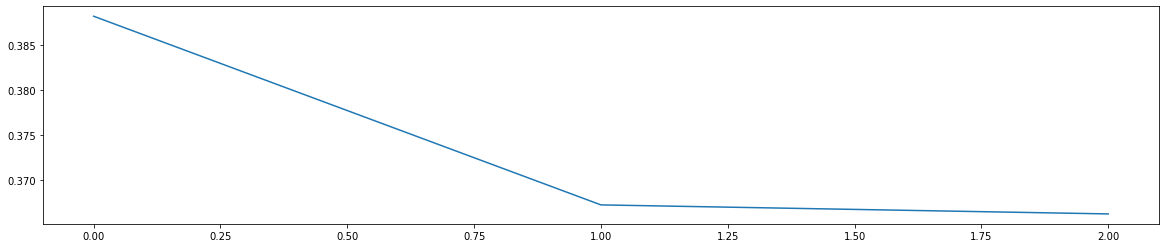

In [36]:
# Constants:
loss = 'binary_crossentropy'
optimizer = 'rmsprop'
epochs = 3
batch_size = 64

# Complie model:
model = Sequential()
model.add(LSTM(100, input_shape=(18,1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
results = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=epochs, verbose=1, shuffle=False, batch_size=batch_size)
model.summary() 

plt.figure(figsize=(20,4))
plt.plot(results.history['loss'])
# plt.plot(results.history['val_loss'])
plt.show()

In [33]:
predictions = model.predict(X_test)
predictions_round = [1 if x > 0.5 else 0 for x in predictions]
pd.Series(predictions_round).value_counts()

0    1136
dtype: int64

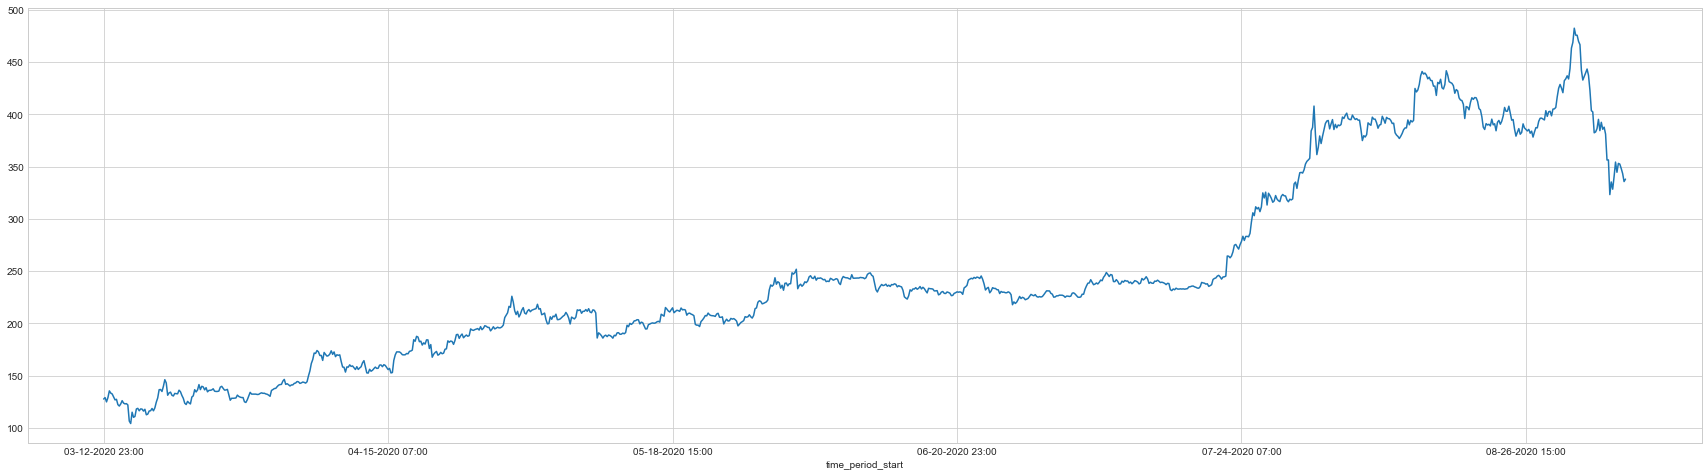

In [34]:
df_plot = df[-len(X_test):]
df_plot['predictions']= predictions_round

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30,8))

df_plot['price_close'].plot()
# df_plot['ma_8'].plot()
# df_plot['ma_13'].plot()
# df_plot['ma_21'].plot()
# df_plot['ma_55'].plot()

for i in range(len(df_plot)):
    if df_plot.iloc[i, 3] == 1:
        plt.annotate('>', (i, df_plot.iloc[i]['price_close']), xytext=(-10, 0), textcoords='offset points', fontsize=14, fontweight='bold')

___

In [86]:
old = X_train.shape
print(old)
new = X_train.transpose(2,0,1).reshape(-1,X_train.shape[1])
print(new.shape)

(4555, 10, 1)
(4555, 10)


In [87]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train.transpose(2,0,1).reshape(-1,X_train.shape[1]), y_train)

RandomForestClassifier(random_state=0)

In [90]:
y_pred = clf.predict(X_test.transpose(2,0,1).reshape(-1,X_test.shape[1]))

In [91]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.99      0.83       818
         1.0       0.27      0.01      0.02       321

    accuracy                           0.71      1139
   macro avg       0.50      0.50      0.43      1139
weighted avg       0.59      0.71      0.60      1139



In [114]:
df_plot = df[-len(X_test):]
df_plot['predictions'] = predictions_round

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30,8))

df_plot['price_close'].plot()

for i in range(len(df_plot)):
    if y_pred[i] == 1:
        plt.annotate('>', (i, df_plot.iloc[i]['price_close']), xytext=(-10, 0), textcoords='offset points', fontsize=14, fontweight='bold')

ValueError: Length of values (1071) does not match length of index (1139)

___

In [109]:
y_train[np.where(y_train == 1)[0]]

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [110]:
X_train[np.where(y_train == 1)[0]].shape

(1149, 10, 1)

In [111]:
np.where(y_train == 0)[0][:1002]

array([   0,    1,    2, ..., 1399, 1400, 1401])

In [112]:
X_train[np.where(y_train == 1)[0]].shape

(1149, 10, 1)

In [113]:
X_train[np.where(y_train == 0)[0][:1002]].shape

(1002, 10, 1)

In [93]:
X_train_balanced = np.concatenate((X_train[np.where(y_train == 1)[0]], X_train[np.where(y_train == 0)[0][:2000]]))
y_train_balanced = np.concatenate((y_train[np.where(y_train == 1)[0]], y_train[np.where(y_train == 0)[0][:2000]]))

Epoch 1/3
99/99 [==============================] - 2s 12ms/step - loss: 1.2596 - accuracy: 0.6304 - val_loss: 0.6012 - val_accuracy: 0.7182
Epoch 2/3
99/99 [==============================] - 0s 4ms/step - loss: 0.7330 - accuracy: 0.5583 - val_loss: 0.6316 - val_accuracy: 0.7182
Epoch 3/3
99/99 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.6351 - val_loss: 0.6208 - val_accuracy: 0.7182
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
___________________________

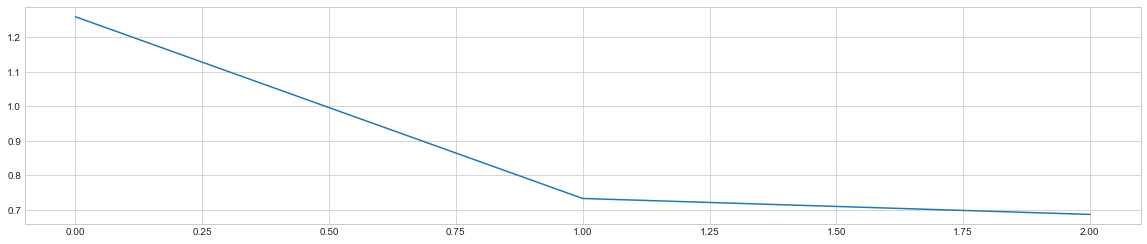

In [94]:
# Complie model:
model = Sequential()
model.add(LSTM(100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
results = model.fit(X_train_balanced, y_train_balanced, epochs=epochs, validation_data=(X_test, y_test), verbose=1, shuffle=False)
model.summary() 

plt.figure(figsize=(20,4))
plt.plot(results.history['loss'])
plt.show()

In [95]:
predictionsn = model.predict(X_test)
predictions_round = [1 if x > 0.5 else 0 for x in predictions]
pd.Series(predictions_round).value_counts()

0    1071
dtype: int64

___

In [102]:
train, test = tensorflow.keras.datasets.imdb.load_data()

In [104]:
# Complie model:
model = Sequential()
model.add(LSTM(100, activation='binary_crossentropy'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
results = model.fit(train[0], train[0], epochs=epochs, validation_data=(test[0],test[1]), verbose=1, shuffle=False)
model.summary() 

ValueError: Unknown activation function: adam. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.